In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm
# ignore Intel MKL WARNING
import os
os.environ['KMP_WARNINGS'] = 'off'

# Data Generation

## Linear Data

In [2]:
# Parameters
mu = np.ones(10) # Mean vector for the weight distribution
I10 = np.identity(10) # Identity matrix for covariates and weights

def generate_contextual_data(N):
    """
    Generate contextual data for a given context size N.
    Returns weights w, covariates X, and corresponding y values.
    """
    c_m = []
    # Draw weight vector w for the context
    w = np.random.multivariate_normal(mu, I10)

    for _ in range(N):
      # Draw covariates xi and compute corresponding yi = wT * xi
      x = np.random.multivariate_normal(np.zeros(10), I10, 1)
      y = np.dot(x, w.T)
      c_m.append((x,y))
    return c_m

## Linear Data with Noise

In [3]:
# Parameters
mu = np.ones(10) # Mean vector for the weight distribution
I10 = np.identity(10) # Identity matrix for covariates and weights
sigma_squared = 1.0  # Variance of the noise

def generate_contextual_data_with_noise(N):
    """
    Generate contextual data for a given context size N.
    Returns covariates X, and corresponding noisy y values.
    """
    c_m = []
    # Draw weight vector w for the context
    w = np.random.multivariate_normal(mu, I10)

    for _ in range(N):
        # Draw covariates xi
        x = np.random.multivariate_normal(np.zeros(10), I10, 1)
        # Generate noise epsilon_i from N(0, sigma_squared)
        epsilon = np.random.normal(0, sigma_squared)
        # Compute corresponding yi = wT * xi + epsilon
        y = np.dot(x, w.T) + epsilon
        c_m.append((x, y))
    return c_m

## Non-linear Data with Noise

In [4]:
d = 10
# Identity matrix for weights
Id = np.identity(d)

# Define v and u based on cos(jπ/5) and sin(jπ/5)
j = np.arange(1, d + 1)
v = np.cos(j * np.pi / 5)
u = np.sin(j * np.pi / 5)

def generate_contextual_data_non_linear(N):
    """
    Generate contextual data for a given context size N.
    Returns covariates X, and corresponding y values.
    """
    c_m = []
    # Draw weight vector w_m for the context from N(0_d, I_d)
    w_m = np.random.multivariate_normal(np.zeros(d), Id)

    for _ in range(N):
        # Draw α, β from N(0, 1)
        alpha = np.random.normal(0, 1)
        beta = np.random.normal(0, 1)
        # Generate ε with each ε_j from N(0, 1/100)
        epsilon = np.random.normal(0, np.sqrt(1/100), d)
        # Compute xm,i = αv + βu + ε
        x_m_i = alpha * v + beta * u + epsilon
        # Compute corresponding ym,i = w_m^T xm,i
        y_m_i = np.dot(w_m, x_m_i)
        c_m.append((x_m_i, y_m_i))
    return c_m

In [88]:
# sample non-linear data with guassian distribution with bias
def generate_contextual_data_non_linear_with_bias(N):
    """
    Generate contextual data for a given context size N.
    Returns covariates X, and corresponding y values.
    """
    c_m = []
    # Draw weight vector w_m for the context from N(0_d, I_d)
    w_m = np.random.multivariate_normal(np.zeros(d), Id)

    for _ in range(N):
        # Draw α, β from N(0, 1)
        alpha = np.random.normal(0, 1)
        beta = np.random.normal(0, 1)
        # Generate ε with each ε_j from N(0, 1/100)
        epsilon = np.random.normal(0, np.sqrt(1/100), d)
        # Compute xm,i = αv + βu + ε
        x_m_i = alpha * v + beta * u + epsilon
        # Compute corresponding ym,i = w_m^T xm,i + bias
        y_m_i = np.dot(w_m, x_m_i) + np.random.normal(0, 1)
        c_m.append((x_m_i, y_m_i))
    return c_m

In [95]:
# generate non-linear data with exponential guassian distribution with bias
def generate_contextual_data_non_linear_with_bias_exp(N):
    """
    Generate contextual data for a given context size N.
    Returns covariates X, and corresponding y values.
    """
    c_m = []
    # Draw weight vector w_m for the context from N(0_d, I_d)
    w_m = np.random.multivariate_normal(np.zeros(d), Id)

    for _ in range(N):
        # Draw α, β from N(0, 1)
        alpha = np.random.normal(0, 1)
        beta = np.random.normal(0, 1)
        # Generate ε with each ε_j from N(0, 1/100)
        epsilon = np.random.normal(0, np.sqrt(1/100), d)
        # Compute xm,i = αv + βu + ε
        x_m_i = alpha * v + beta * u + epsilon
        # Compute corresponding ym,i = w_m^T xm,i + bias
        y_m_i = np.dot(w_m, x_m_i) + np.random.exponential(1)
        c_m.append((x_m_i, y_m_i))
    return c_m

In [ ]:
# generate non-linear data from a kernel guassian distribution with bias
def generate_contextual_data_non_linear_with_bias_kernel(N):
    """
    Generate contextual data for a given context size N.
    Returns covariates X, and corresponding y values.
    """
    c_m = []
    # Draw weight vector w_m for the context from N(0_d, I_d)
    w_m = np.random.multivariate_normal(np.zeros(d), Id)

    for _ in range(N):
        # Draw α, β from N(0, 1)
        alpha = np.random.normal(0, 1)
        beta = np.random.normal(0, 1)
        # Generate ε with each ε_j from N(0, 1/100)
        epsilon = np.random.normal(0, np.sqrt(1/100), d)
        # Compute xm,i = αv + βu + ε
        x_m_i = alpha * v + beta * u + epsilon
        # Compute corresponding ym,i = w_m^T xm,i + bias
        y_m_i = np.dot(w_m, x_m_i) + np.random.normal(0, 1) + np.random.normal(0, 1)
        c_m.append((x_m_i, y_m_i))
    return c_m

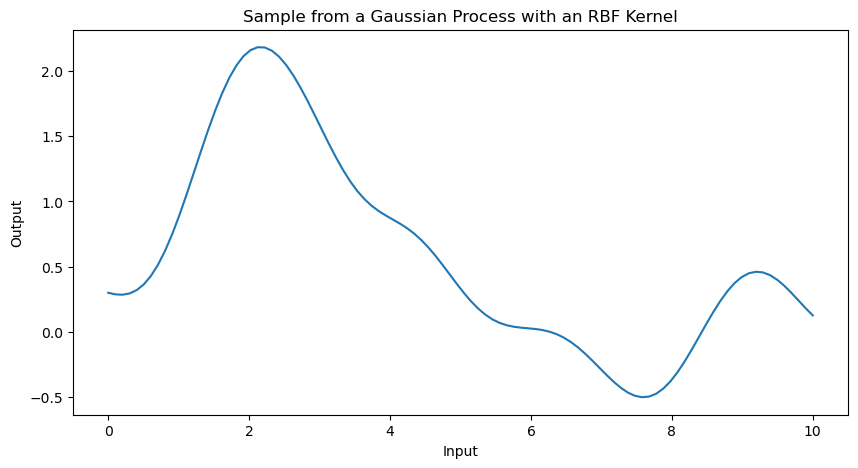

In [97]:
import numpy as np

# Define the RBF kernel function
def rbf_kernel(X1, X2, length_scale=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 / length_scale**2 * sqdist)

# Generate input points
X = np.linspace(0, 10, 100).reshape(-1, 1)

# Compute the covariance matrix using the RBF kernel
K = rbf_kernel(X, X)

# Generate random outputs from the multivariate normal distribution
Y = np.random.multivariate_normal(mean=np.zeros(100), cov=K)


# Data from Kernels

In [1]:
from numpy.linalg import eigh
from scipy.stats import special_ortho_group

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def sample_from_sphere(N, d):
    """ Generate N d-dimensional vectors uniformly sampled from the unit sphere. """
    xi = np.random.randn(N, d)
    xi /= np.linalg.norm(xi, axis=1, keepdims=True)
    return xi

def generate_covariates(N, d=10):
    """ Generate N covariates x^{(i)} based on the description. """
    D = np.diag([1, 1, 0.25, 2.25, 1] + [1] * (d - 5))
    U = special_ortho_group.rvs(dim=d)
    Sigma_sqrt = U.T @ np.sqrt(D) @ U
    xi = sample_from_sphere(N, d)
    return Sigma_sqrt @ xi.T

def kernel_matrix(X, kernel_type='linear'):
    """ Compute the kernel matrix for different types of kernels. """
    if kernel_type == 'linear':
        return X.T @ X
    elif kernel_type == 'relu':
        return np.maximum(X.T @ X, 0)
    elif kernel_type == 'exp':
        return np.exp(X.T @ X)

def gaussian_process(N, kernel_type):
    """ Generate labels y^{(i)} using a Gaussian Process. """
    X = generate_covariates(N)
    K = kernel_matrix(X, kernel_type=kernel_type)
    eigvals, eigvecs = eigh(K)
    K_plus = eigvecs @ np.diag(np.abs(eigvals)) @ eigvecs.T
    X = X.T
    return X, np.random.multivariate_normal(np.zeros(N), K_plus)

In [3]:
def generate_contextual_data_gp(N, kernel_type='linear'):
    """
    Generate contextual data for a given context size N.
    Returns covariates X, and corresponding y values.
    """
    X, y = gaussian_process(N, kernel_type=kernel_type)
    c_m = [(x, y) for x, y in zip(X, y)]
    return c_m

# Designed Kernel Attention

In [5]:
def rbf_kernel(x1, x2, sigma=1.0):
    """
    Compute the RBF kernel between two vectors x1 and x2.
    x1: tensor, shape torch.Size([5, 11])
    x2: tensor, shape torch.Size([5, 11])
    """
    X_expanded = x1.unsqueeze(1)  # Shape becomes [5, 1, 11]
    Y_expanded = x2.unsqueeze(0)  # Shape becomes [1, 5, 11]
    pairwise_diff = X_expanded - Y_expanded
    squared_distances = torch.norm(pairwise_diff, dim=2) ** 2
    output = torch.exp(-squared_distances / (sigma ** 2))
    # # normalize the kernel
    # output = output / torch.sum(output, dim=1, keepdim=True)
    # print(output)
    return output

In [90]:
def laplacian_kernel(x1, x2, sigma=1.0):
    """
    Compute the exponential kernel between two vectors x1 and x2.
    x1: tensor, shape torch.Size([5, 11])
    x2: tensor, shape torch.Size([5, 11])
    """
    X_expanded = x1.unsqueeze(1)  # Shape becomes [5, 1, 11]
    Y_expanded = x2.unsqueeze(0)  # Shape becomes [1, 5, 11]
    pairwise_diff = X_expanded - Y_expanded
    squared_distances = torch.norm(pairwise_diff, dim=2) ** 2
    output = torch.exp(-torch.sqrt(squared_distances) / sigma)
    return output

In [91]:
def exp_kernel(x1, x2):
    """
    Compute the exponential kernel between two vectors x1 and x2.
    x1: tensor, shape torch.Size([5, 11])
    x2: tensor, shape torch.Size([5, 11])
    kernel = exp()
    """
    output = torch.exp(torch.matmul(x1, x2.T))
    print(output)
    return output

In [6]:
class DesignedKernelAttention(nn.Module):
    def __init__(self, dim, alpha):
        super(DesignedKernelAttention, self).__init__()
        self.dim = dim
        self.alpha = alpha

        # Define multi-head configuration
        self.num_heads = 2

        # Initialize weights for each head
        self.W_q = nn.ParameterList([
            nn.Parameter(torch.eye(self.dim + 1), requires_grad=False),
            nn.Parameter(torch.zeros(self.dim + 1, self.dim+1), requires_grad=False)
        ])
        self.W_q[0][self.dim, self.dim] = 0
        
        self.W_k = nn.ParameterList([
            nn.Parameter(torch.eye(self.dim + 1), requires_grad=False),
            nn.Parameter(torch.zeros(self.dim + 1, self.dim+1), requires_grad=False)
        ])
        self.W_k[0][self.dim, self.dim] = 0

        self.W_v = nn.Parameter(torch.zeros(self.dim+1, self.dim+1), requires_grad=False)
        self.W_v[self.dim, self.dim] = -self.alpha

    def forward(self, x):
        # Apply multi-head attention by adding outputs from each head
        multi_head_output = torch.zeros(x.size(0), self.dim+1)

        for i in range(self.num_heads):
            Q = torch.matmul(x, self.W_q[i].T)
            K = torch.matmul(x, self.W_k[i].T)
            V = torch.matmul(x, self.W_v.T)

            # Use RBF kernel on Q and K to calculate attention scores
            # kernel_attention_scores = rbf_kernel(Q, K)
            kernel_attention_scores = exp_kernel(Q, K)
            # print(kernel_attention_scores)
            # transfer kernel_attention_scores to a tensor
            # if i==0:
            #     # normalize the kernel
            #     kernel_attention_scores = kernel_attention_scores / torch.sum(kernel_attention_scores, dim=1, keepdim=True)
            output = torch.matmul(kernel_attention_scores, V)
            multi_head_output += output

        return multi_head_output

In [7]:
class DesignedKernelTransformer(nn.Module):
    def __init__(self, input_dim, alpha, num_layers):
        super(DesignedKernelTransformer, self).__init__()
        self.num_layers = num_layers
        self.attention = DesignedKernelAttention(input_dim, alpha)

    def forward(self, x):
        for _ in range(self.num_layers):
            attention_output = self.attention(x)
            x = x + attention_output
        return x

# Test

In [ ]:
lr = 0.001
epochs = 1000
losses = []
for N in range(5, 21):
    criterion = nn.MSELoss()
    mse_loss = []

    for epoch in tqdm.trange(epochs):
        model = DesignedKernelTransformer(10, lr, 12)
        # test_data = generate_contextual_data_with_noise(N)
        # test_data = generate_contextual_data_non_linear_with_bias_exp(N)
        test_data = generate_contextual_data_gp(N, kernel_type='exp')
        x, y = zip(*test_data)
        x = torch.tensor(x).squeeze().float()
        y = torch.tensor(y).squeeze().float()
        y_true = y[-1]
        x = torch.cat([x, y.unsqueeze(1)], dim=1)
        x[-1, -1] = 0
        output = model(x)
        loss = criterion(-output[-1, -1], y_true)
        mse_loss.append(loss.item())

    print(f"Adaptation loss: N={N}, Loss={np.mean(mse_loss)}")
    losses.append(np.mean(mse_loss))